In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
import time
import ott

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP, MLP_FM

from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import pandas as pd
from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2

2023-07-11 06:36:12.126439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from entot.models.utils import MixtureNormalSampler
source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

In [5]:
neural_net = MLP_FM2(1, 128, 128, 128, n_frequencies=5)

In [6]:
otfm = OTFlowMatching(neural_net, epsilon=1e-2, input_dim=1, output_dim=1, iterations=10_000)#, latent_to_data_solver=ott.solvers.linear.sinkhorn.Sinkhorn())

In [7]:
otfm(source, target, 64, 64)

2023-07-10 16:54:19.783149: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 10000/10000 [05:08<00:00, 32.44it/s]


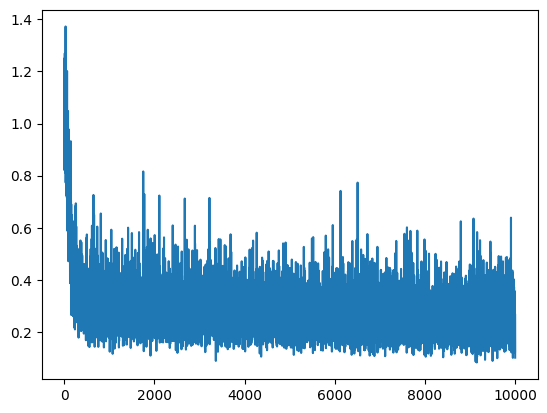

In [10]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

<Axes: ylabel='Density'>

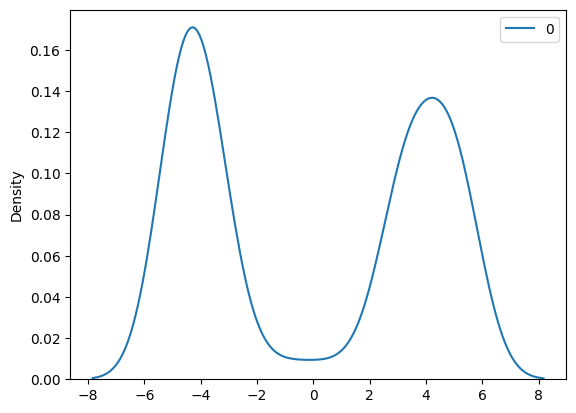

In [8]:
res,_ = otfm.transport(source, seed=0)
sns.kdeplot(res[0,...])

<Axes: ylabel='Density'>

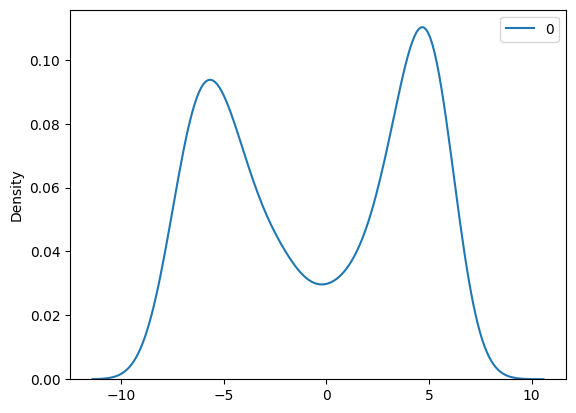

In [8]:
res,_ = otfm.transport(source, seed=0)
sns.kdeplot(res[0,...])

In [15]:
source_repeat = jnp.ones((1,)) * 2
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

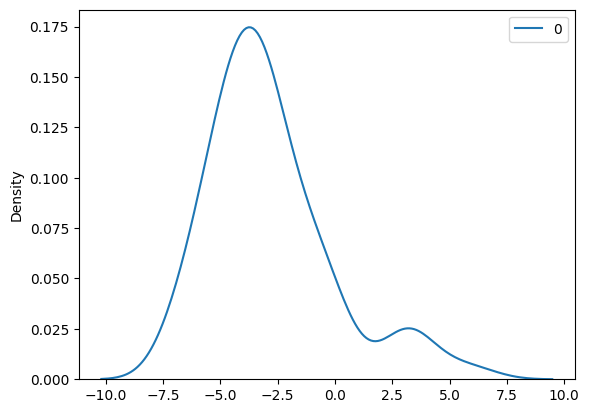

In [16]:
sns.kdeplot(res_const[0,...])

In [36]:
source_repeat = jnp.ones((1,)) * 0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

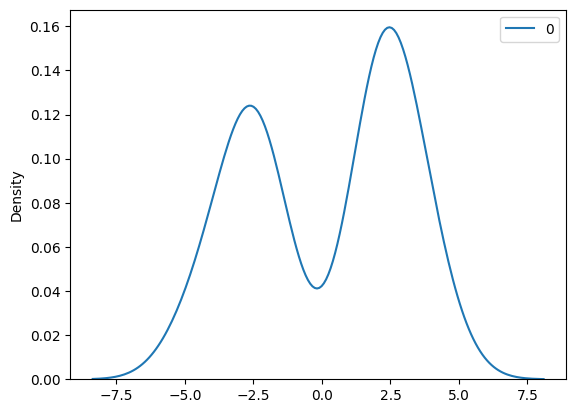

In [37]:
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

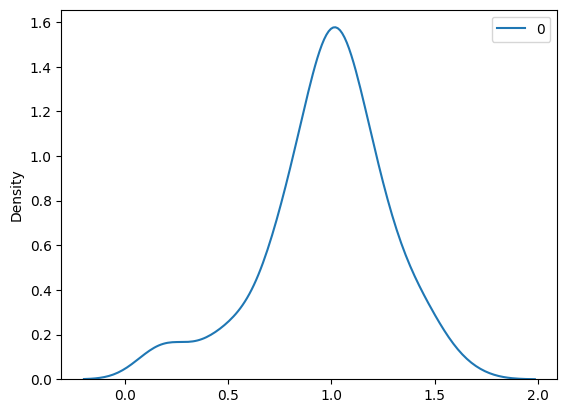

In [40]:
source_repeat = jnp.ones((1,)) * 0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

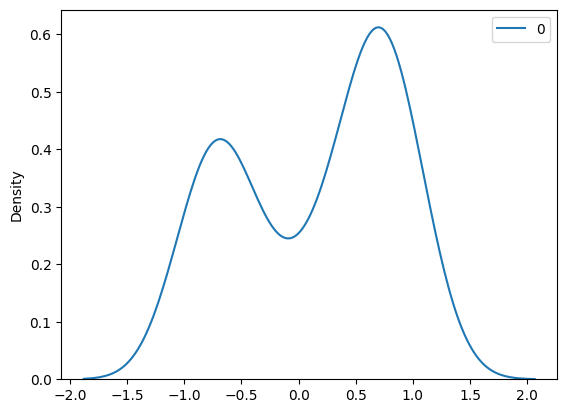

In [41]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

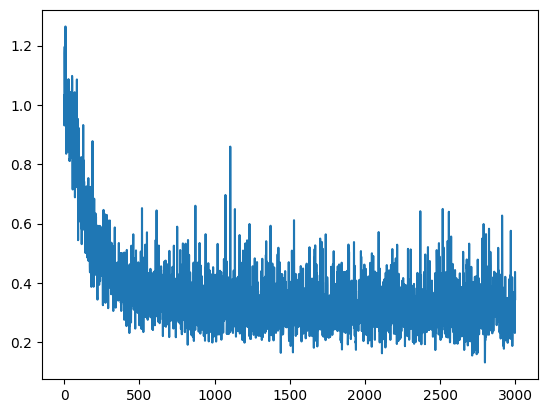

In [40]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])